# Lecture 3B - Jaynes-Cummings-like model in the ultrastrong coupling regime

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johansson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, basis, destroy, entropy_vn, expect, mesolve, ptrace,
                   qeye, tensor, wigner)

%matplotlib inline

# Introduction

In the Jaynes-Cumming model, the dipole-interaction term between the atom and the cavity field is assumed to be weak, so that a rotating-wave approximation can be performed. For large coupling strengths between the atom and the cavity field the RWA is not justified, and for very large coupling strength interesting properties of the atom-cavity ground state is observed.

To explore this using QuTiP, consider the Hamiltonian

### $H = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger + a)(\sigma_- + \sigma_+)$.

Note that here we have not transformed the interaction part of the Hamiltonian using the RWA, for which the Hamiltonian would have been

### $H_{\rm RWA} = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger\sigma_- + a\sigma_+)$.

In this notebook we will calculate the ground state of the Hamiltonian $H$ as a function of the interaction strength $g$ (try to set `use_rwa = True` to use $H_{\rm RWA}$ instead).

The regime $g$ is large compared with all other energy scales in the Hamiltonian $H$ is called the ultrastrong coupling regime, and has been an active topic of research in recent years. See references below.


References:

 * [P. Nataf et al., Phys. Rev. Lett. 104, 023601 (2010)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.104.023601)

 * [J. Casanova et al., Phys. Rev. Lett. 105, 26360 (2010)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.105.263603).

 * [S. Ashhab et al., Phys. Rev. A 81, 042311 (2010)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.81.042311)

### Problem parameters


Here we use units where $\hbar = 1$: 

In [2]:
wc = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # atom frequency

N = 15  # number of cavity fock states
use_rwa = False

### Setup the operators and the Hamiltonian

In [3]:
# operators
a = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))

na = sm.dag() * sm  # atom
nc = a.dag() * a  # cavity

# decoupled Hamiltonian
H0 = wc * a.dag() * a + wa * sm.dag() * sm

# interaction Hamiltonian
if use_rwa:
    H1 = a.dag() * sm + a * sm.dag()
else:
    H1 = (a.dag() + a) * (sm + sm.dag())

## Find ground state as a function of coupling strength

In [4]:
g_vec = np.linspace(0, 2.0, 101) * 2 * np.pi  # coupling strength vector

psi_list = []

for g in g_vec:

    H = H0 + g * H1

    # find the ground state and its energy
    gnd_energy, gnd_state = H.groundstate()

    # store the ground state
    psi_list.append(gnd_state)

Calculate the cavity and atom excitation probabilities as for the calculated ground states:

In [5]:
na_expt = expect(na, psi_list)  # qubit  occupation probability
nc_expt = expect(nc, psi_list)  # cavity occupation probability

Plot the ground state occupation probabilities of the cavity and the atom as a function of coupling strength. Note that for large coupling strength (the ultrastrong coupling regime, where $g > \omega_a,\omega_c$), the ground state has both photonic and atomic excitations.

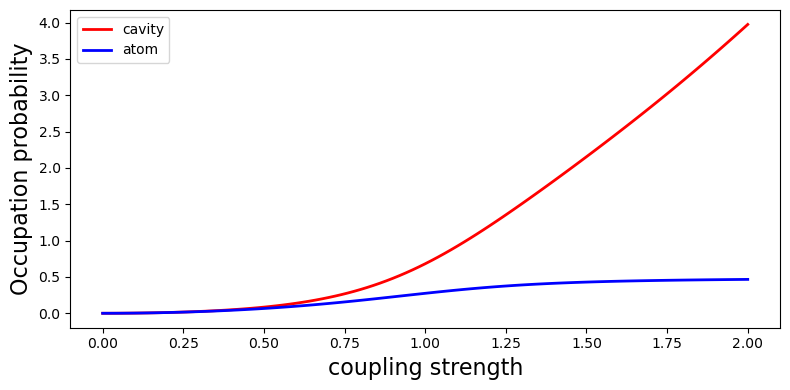

In [6]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 4))

axes.plot(g_vec / (2 * np.pi), nc_expt, "r", linewidth=2, label="cavity")
axes.plot(g_vec / (2 * np.pi), na_expt, "b", linewidth=2, label="atom")
axes.set_ylabel("Occupation probability", fontsize=16)
axes.set_xlabel("coupling strength", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()

# Plot the wigner functions of the cavity as a function of coupling strength

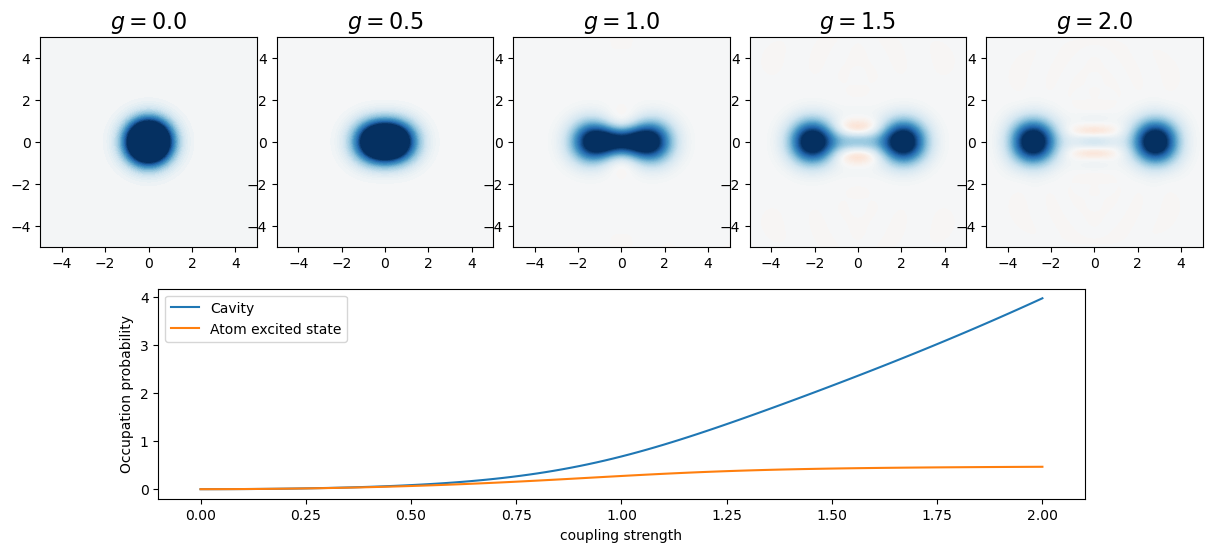

In [7]:
g_idx = np.where([g_vec == 2 * np.pi * g for
                  g in [0.0, 0.5, 1.0, 1.5, 2.0]])[1]
psi_sublist = []
for idx in g_idx:
    psi_sublist.append(psi_list[idx])

xvec = np.linspace(-5, 5, 200)

fig_grid = (2, len(psi_sublist) * 2)
fig = plt.figure(figsize=(3 * len(psi_sublist), 6))

for idx, psi in enumerate(psi_sublist):
    rho_cavity = ptrace(psi, 0)
    W = wigner(rho_cavity, xvec, xvec)
    ax = plt.subplot2grid(fig_grid, (0, 2 * idx), colspan=2)
    ax.contourf(
        xvec,
        xvec,
        W,
        100,
        norm=mpl.colors.Normalize(-0.125, 0.125),
        cmap=plt.get_cmap("RdBu"),
    )
    ax.set_title(r"$g = %.1f$" % (g_vec[g_idx][idx] / (2 * np.pi)),
                 fontsize=16)

# plot the cavity occupation probability in the ground state
ax = plt.subplot2grid(fig_grid, (1, 1), colspan=(fig_grid[1] - 2))
ax.plot(g_vec / (2 * np.pi), nc_expt, label="Cavity")
ax.plot(g_vec / (2 * np.pi), na_expt, label="Atom excited state")
ax.legend(loc=0)
ax.set_xlabel("coupling strength")
ax.set_ylabel("Occupation probability");

## Entropy of atom/cavity as a measure of entanglement

In [8]:
entropy_cavity = np.zeros(g_vec.shape)
entropy_atom = np.zeros(g_vec.shape)

for idx, psi in enumerate(psi_list):

    rho_cavity = ptrace(psi, 0)
    entropy_cavity[idx] = entropy_vn(rho_cavity, 2)

    rho_atom = ptrace(psi, 1)
    entropy_atom[idx] = entropy_vn(rho_atom, 2)

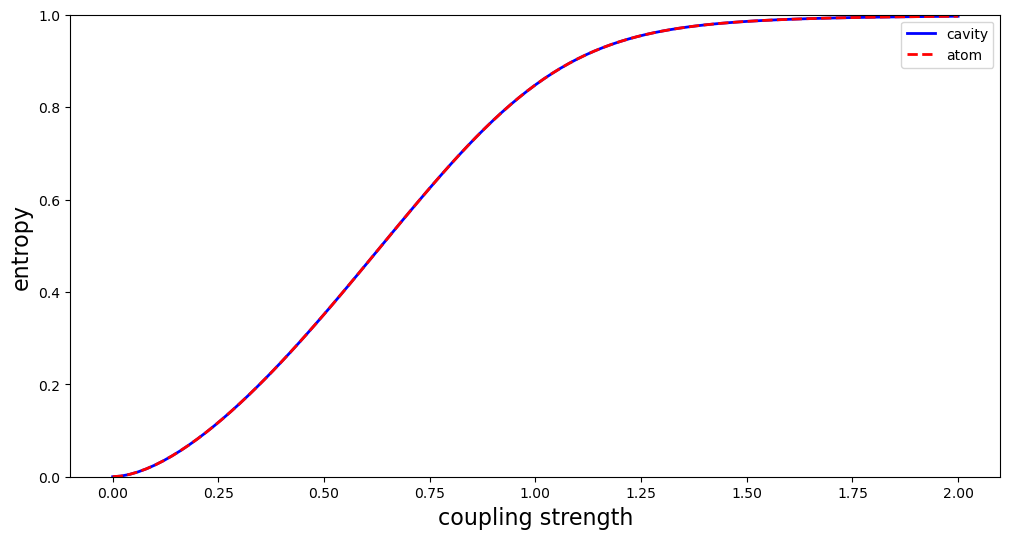

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.plot(g_vec / (2 * np.pi), entropy_cavity, "b", label="cavity",
          linewidth=2)
axes.plot(g_vec / (2 * np.pi), entropy_atom, "r--", label="atom", linewidth=2)
axes.set_ylim(0, 1)
axes.set_ylabel("entropy", fontsize=16)
axes.set_xlabel("coupling strength", fontsize=16)
axes.legend(loc=0);

## Dynamics of an initially excited cavity

In [10]:
H = H0 + 1.0 * 2 * np.pi * H1

psi0 = tensor(basis(N, 1), basis(2, 0))

In [11]:
tlist = np.linspace(0, 20, 1000)
output = mesolve(H, psi0, tlist, [], [a.dag() * a, sm.dag() * sm])

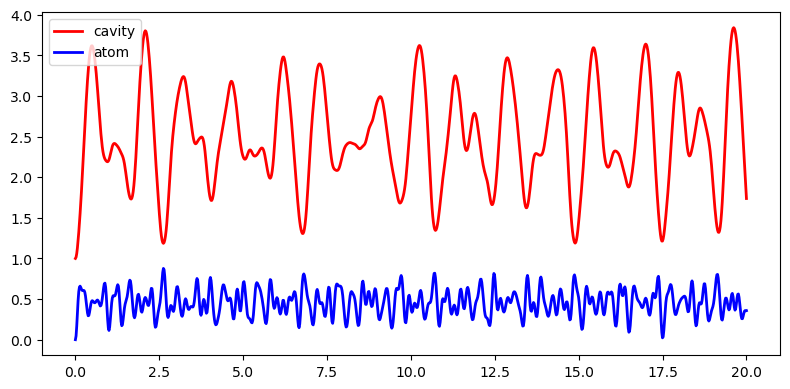

In [12]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 4))

axes.plot(tlist, np.real(output.expect[0]), "r", linewidth=2, label="cavity")
axes.plot(tlist, np.real(output.expect[1]), "b", linewidth=2, label="atom")
axes.legend(loc=0)

fig.tight_layout()

### Fock-state distribution and Wigner function for the cavity as a function of time

In [13]:
tlist = np.linspace(0, 0.35, 8)
output = mesolve(H, psi0, tlist, [], [])

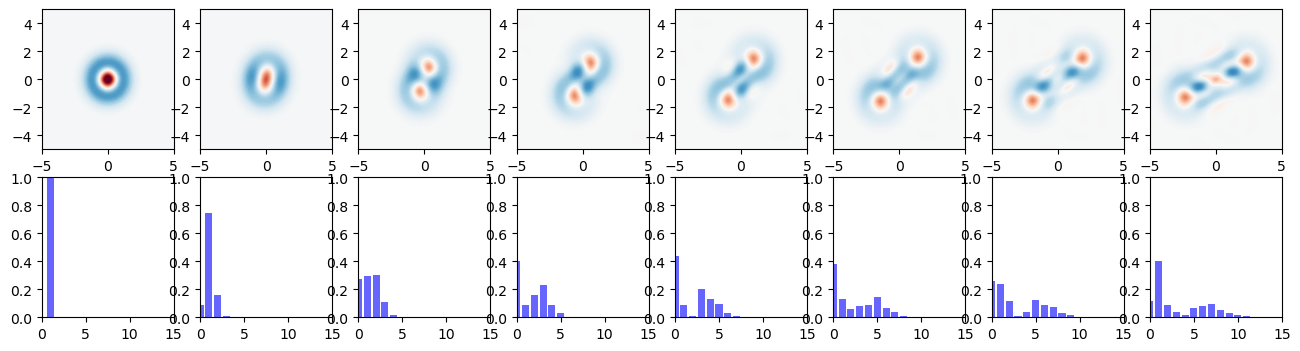

In [14]:
rho_ss_sublist = output.states  # [::4]

xvec = np.linspace(-5, 5, 200)

fig, axes = plt.subplots(2, len(rho_ss_sublist),
                         figsize=(2 * len(rho_ss_sublist), 4))

for idx, rho_ss in enumerate(rho_ss_sublist):

    # trace out the cavity density matrix
    rho_ss_cavity = ptrace(rho_ss, 0)

    # calculate its wigner function
    W = wigner(rho_ss_cavity, xvec, xvec)

    # plot its wigner function
    axes[0, idx].contourf(
        xvec,
        xvec,
        W,
        100,
        norm=mpl.colors.Normalize(-0.25, 0.25),
        cmap=plt.get_cmap("RdBu"),
    )

    # plot its fock-state distribution
    axes[1, idx].bar(
        np.arange(0, N), np.real(rho_ss_cavity.diag()), color="blue", alpha=0.6
    )
    axes[1, idx].set_ylim(0, 1)
    axes[1, idx].set_xlim(0, N)

### Same thing with a little bit of dissipation

In [15]:
kappa = 0.25

In [16]:
tlist = np.linspace(0, 20, 1000)
output = mesolve(H, psi0, tlist, [np.sqrt(kappa) * a],
                 [a.dag() * a, sm.dag() * sm])

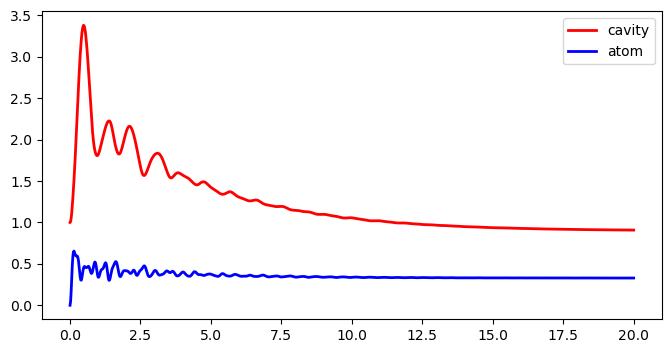

In [17]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 4))
axes.plot(tlist, output.expect[0], "r", linewidth=2, label="cavity")
axes.plot(tlist, output.expect[1], "b", linewidth=2, label="atom")
axes.legend(loc=0);

In [18]:
tlist = np.linspace(0, 10, 8)
output = mesolve(H, psi0, tlist, [np.sqrt(kappa) * a], [])

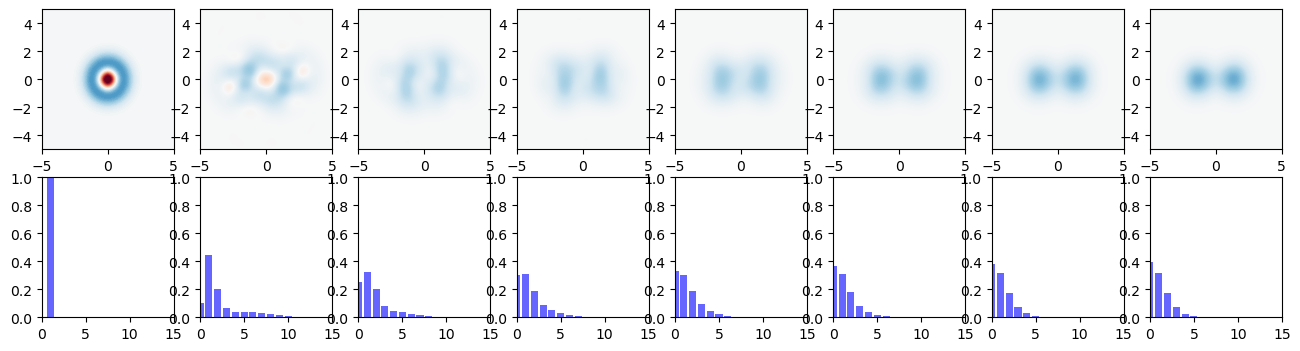

In [19]:
xvec = np.linspace(-5, 5, 200)

fig, axes = plt.subplots(2, len(output.states),
                         figsize=(2 * len(output.states), 4))

for idx, rho_ss in enumerate(output.states):

    # trace out the cavity density matrix
    rho_ss_cavity = ptrace(rho_ss, 0)

    # calculate its wigner function
    W = wigner(rho_ss_cavity, xvec, xvec)

    # plot its wigner function
    axes[0, idx].contourf(
        xvec,
        xvec,
        W,
        100,
        norm=mpl.colors.Normalize(-0.25, 0.25),
        cmap=plt.get_cmap("RdBu"),
    )

    # plot its fock-state distribution
    axes[1, idx].bar(
        np.arange(0, N), np.real(rho_ss_cavity.diag()), color="blue", alpha=0.6
    )
    axes[1, idx].set_ylim(0, 1)
    axes[1, idx].set_xlim(0, N)

### Entropy as a function of time in presence of dissipation and starting in the ideal ground state

In [20]:
tlist = np.linspace(0, 30, 50)

psi0 = H.groundstate()[1]

output = mesolve(H, psi0, tlist, [np.sqrt(kappa) * a], [])

In [21]:
entropy_tot = np.zeros(tlist.shape)
entropy_cavity = np.zeros(tlist.shape)
entropy_atom = np.zeros(tlist.shape)

for idx, rho in enumerate(output.states):

    entropy_tot[idx] = entropy_vn(rho, 2)

    rho_cavity = ptrace(rho, 0)
    entropy_cavity[idx] = entropy_vn(rho_cavity, 2)

    rho_atom = ptrace(rho, 1)
    entropy_atom[idx] = entropy_vn(rho_atom, 2)

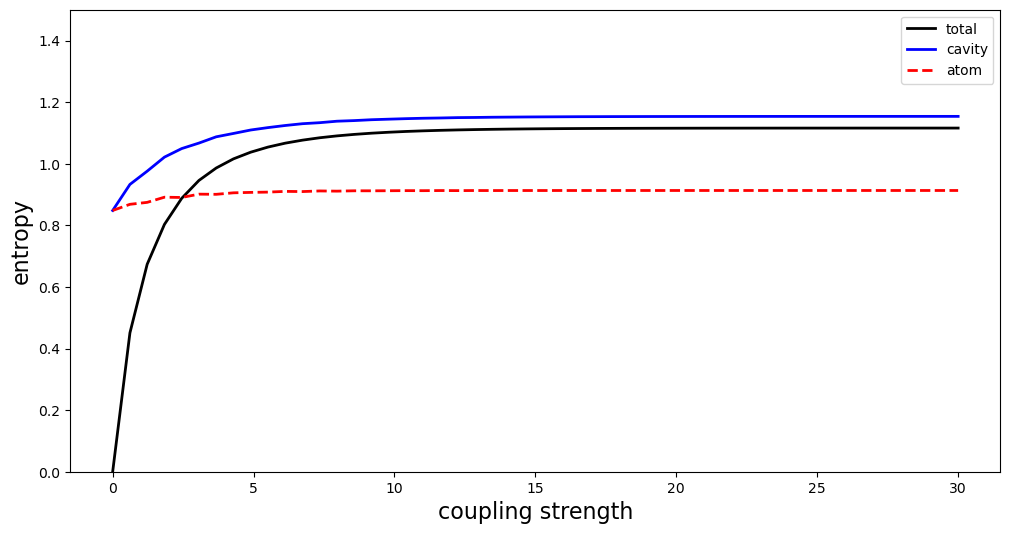

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.plot(tlist, entropy_tot, "k", label="total", linewidth=2)
axes.plot(tlist, entropy_cavity, "b", label="cavity", linewidth=2)
axes.plot(tlist, entropy_atom, "r--", label="atom", linewidth=2)
axes.set_ylabel("entropy", fontsize=16)
axes.set_xlabel("coupling strength", fontsize=16)
axes.set_ylim(0, 1.5)
axes.legend(loc=0);

### Software versions

In [23]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.6
Numpy Version:      1.26.4
Scipy Version:      1.12.0
Cython Version:     0.29.37
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     4
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v4/lib/python3.10/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex refer